# T-evolution of Period and Amplitude  

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folde
import pandas as pd

In [2]:
sys.path.append('../AppStat/AppStat2021/External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

sys.path.append('../AppStat/AppStat2021/Emilie_External_Functions')
from EmilieExternalFunctions import zerobin_hist, chi2_test, get_chi2_values

sys.path.append('BachelorExternalFunctions')
from Bachelor_ExternalFunctions import peak_plotter, peak_finder, compare_peaks
from Bachelor_ExternalFunctions import amp_plotter, amplitudes, get_min_idx

In [3]:
# Set som plotting standards:

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)


save_plots = True

In [4]:
# Getting the residuals after 4'th order polynomial filter

resi_p = pd.read_csv('Data/resi_p_n4.csv', header=None, index_col=None).to_numpy()
resi_m = pd.read_csv('Data/resi_m_n4.csv', header=None, index_col=None).to_numpy()

In [5]:
# Shifting all mdm2 traces three places: 

roll_resi_m = np.zeros(shape=(402, 238))

for i in range(len(resi_m)): 
    roll_resi_m[i] = np.roll(resi_m[i], -3)
    
roll_resi_m = roll_resi_m.tolist()

In [6]:
# Using the std of the gradient distribution as initial fitting errors

avefluct_m = 3.4505
avefluct_p = 11.3488

print(f'The mean fluctuations before oscillations: {avefluct_m:.2f}(mdm2) and {avefluct_p:.2f}(p53)')

The mean fluctuations before oscillations: 3.45(mdm2) and 11.35(p53)


In [7]:
# Getting peaks and amplitudes 

all_peaks_p_idx = []
all_peaks_m_idx = []

all_amplitudes_p = []
all_amplitudes_m = []

all_norm_amplitudes_p = []
all_norm_amplitudes_m = []

for i in range(len(resi_p)):
    peaks_p, local_min_p = peak_finder(resi_p[i], N_peaks='high', threshold=avefluct_p)
    peaks_m, local_min_m = peak_finder(roll_resi_m[i], N_peaks='high', threshold=avefluct_m)
    
    amps_p = amplitudes(resi_p[i], peaks_p, local_min_p)
    amps_m = amplitudes(roll_resi_m[i], peaks_m, local_min_m)
    
    all_peaks_p_idx.append(peaks_p)
    all_peaks_m_idx.append(peaks_m)
    
    all_amplitudes_p.append(amps_p)
    all_amplitudes_m.append(amps_m)
    
    all_norm_amplitudes_p.append([amps_p[i] / max(amps_p) for i in range(len(amps_p))])
    all_norm_amplitudes_m.append([amps_m[i] / max(amps_m) for i in range(len(amps_m))])

In [8]:
# Filling the amplitudes in on a time-axis according to the peak index

amp_matrix_p = np.zeros(shape=(1, 238))
norm_amp_matrix_p = np.zeros(shape=(1, 238))
NampsAtIdx_p = np.zeros(shape=(1, 238))  # Getting the number of peaks on that time index

amp_matrix_m = np.zeros(shape=(1, 238))
norm_amp_matrix_m = np.zeros(shape=(1, 238))
NampsAtIdx_m = np.zeros(shape=(1, 238))


for i in range(len(all_peaks_p_idx)): 
    amp_matrix_p[0, all_peaks_p_idx[i]] += all_amplitudes_p[i]
    norm_amp_matrix_p[0, all_peaks_p_idx[i]] += all_norm_amplitudes_p[i]
    NampsAtIdx_p[0, all_peaks_p_idx[i]] += 1
    
    amp_matrix_m[0, all_peaks_m_idx[i]] += all_amplitudes_m[i]
    norm_amp_matrix_m[0, all_peaks_m_idx[i]] += all_norm_amplitudes_m[i]
    NampsAtIdx_m[0, all_peaks_m_idx[i]] += 1

In [9]:
# Dividing by the number of peaks on that time index

amp_matrix_p = [amp_matrix_p[0][i] / NampsAtIdx_p[0][i] for i in range(2, 236)]
amp_matrix_m = [amp_matrix_m[0][i] / NampsAtIdx_m[0][i] for i in range(2, 236)]

norm_amp_matrix_p = [norm_amp_matrix_p[0][i] / NampsAtIdx_p[0][i] for i in range(2, 236)]
norm_amp_matrix_m = [norm_amp_matrix_m[0][i] / NampsAtIdx_m[0][i] for i in range(2, 236)]

In [10]:
# Fitting the time-evolution of the amplitudes 

time = np.linspace(0, 287/2, 287)
t = time[49:]

norm_coef_p = np.polyfit(t[10:236], norm_amp_matrix_p[8:], 2)
norm_coef_m = np.polyfit(t[10:236], norm_amp_matrix_m[8:], 2)
    
norm_fit_p = np.polyval(norm_coef_p[:], t[10:236])
norm_fit_m = np.polyval(norm_coef_m[:], t[10:236])

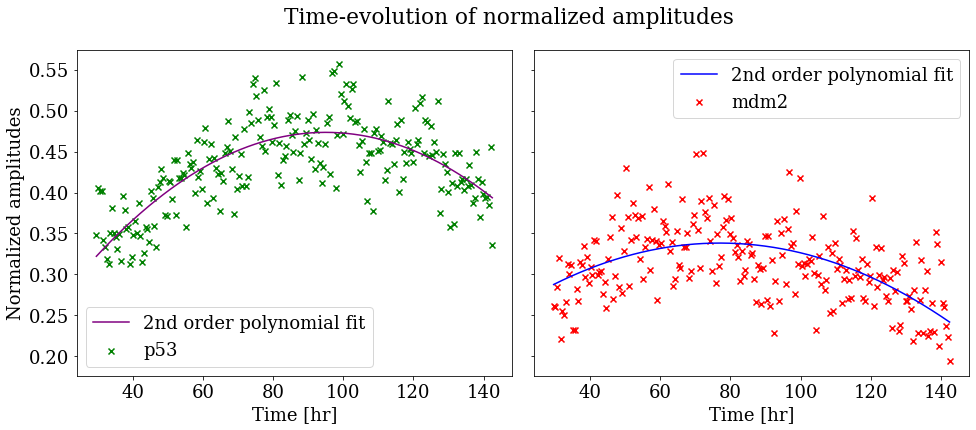

In [18]:
# Plotting 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharey=True)

suptitle = fig.suptitle('Time-evolution of normalized amplitudes')

ax[0].scatter(t[10:236], norm_amp_matrix_p[8:], marker='x', color='green', label='p53')
ax[0].plot(t[10:236], norm_fit_p, color='purple', label='2nd order polynomial fit')
ax[1].scatter(t[10:236], norm_amp_matrix_m[8:], marker='x', color='red', label='mdm2')
ax[1].plot(t[10:236], norm_fit_m, color='blue', label='2nd order polynomial fit')

ax[0].set(xlabel='Time [hr]', 
          ylabel='Normalized amplitudes')

ax[1].set(xlabel='Time [hr]')

fig.subplots_adjust(wspace=0.05)

ax[0].legend()
ax[1].legend()


if save_plots: 
    plt.savefig(r'Graphs/T_Evo_Amps.png', bbox_inches='tight', bbox_extra_artists=[suptitle])

In [12]:
# Finding the time between peaks

t_between_peaks_p = [np.diff(all_peaks_p_idx[i]) for i in range(len(all_peaks_p_idx))]
t_between_peaks_m = [np.diff(all_peaks_m_idx[i]) for i in range(len(all_peaks_m_idx))]

In [13]:
# Filling the amplitudes in on a time-axis according to the peak index

peri_matrix_p = np.zeros(shape=(1, 238))
NperiAtIdx_p = np.zeros(shape=(1, 238))  # Getting the number of peaks on that time index

peri_matrix_m = np.zeros(shape=(1, 238))
NperiAtIdx_m = np.zeros(shape=(1, 238))


for i in range(len(all_peaks_p_idx)): 
    idx_p = all_peaks_p_idx[i].copy()
    idx_p.pop()
    peri_matrix_p[0, idx_p] += t_between_peaks_p[i]
    NperiAtIdx_p[0, all_peaks_p_idx[i]] += 1
    
    idx_m = all_peaks_m_idx[i].copy()
    idx_m.pop()
    peri_matrix_m[0, idx_m] += t_between_peaks_m[i]
    NperiAtIdx_m[0, all_peaks_m_idx[i]] += 1

In [14]:
# Getting the average periods: 

peri_matrix_p = [peri_matrix_p[0][i] / NperiAtIdx_p[0][i] * 0.5 for i in range(2, 233)]
peri_matrix_m = [peri_matrix_m[0][i] / NperiAtIdx_m[0][i] * 0.5 for i in range(2, 233)]

In [15]:
# Fitting the time-evolution of the periods

peri_coef_p = np.polyfit(t[2:233-8], peri_matrix_p[:-8], 1)
peri_coef_m = np.polyfit(t[2:233-8], peri_matrix_m[:-8], 1)
    
peri_fit_p = np.polyval(peri_coef_p[:], t[2:233-8])
peri_fit_m = np.polyval(peri_coef_m[:], t[2:233-8])

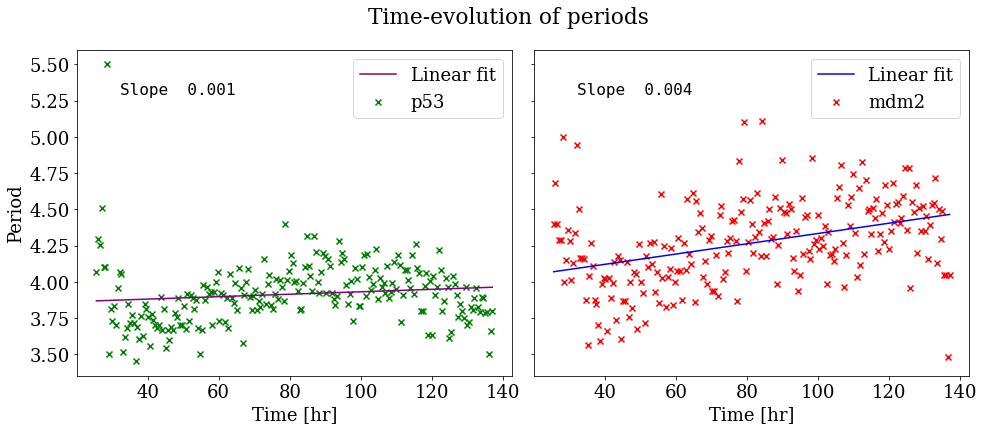

In [19]:
# Plotting 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharey=True)

suptitle = fig.suptitle('Time-evolution of periods')

ax[0].scatter(t[2:233-8], peri_matrix_p[:-8], marker='x', color='green', label='p53')
ax[0].plot(t[2:233-8], peri_fit_p, color='purple', label='Linear fit')
ax[1].scatter(t[2:233-8], peri_matrix_m[:-8], marker='x', color='red', label='mdm2')
ax[1].plot(t[2:233-8], peri_fit_m, color='blue', label='Linear fit')

ax[0].set(xlabel='Time [hr]', 
          ylabel='Period')

ax[1].set(xlabel='Time [hr]')

fig.subplots_adjust(wspace=0.05)

ax[0].legend()
ax[1].legend()

s_p = {'Slope':   peri_coef_p[0]}
text_p = nice_string_output(s_p, extra_spacing=2, decimals=3)
add_text_to_ax(0.1, 0.9, text_p, ax[0], fontsize=16, color='black')

s_m = {'Slope':   peri_coef_m[0]}
text_m = nice_string_output(s_m, extra_spacing=2, decimals=3)
add_text_to_ax(0.1, 0.9, text_m, ax[1], fontsize=16, color='black')

if save_plots: 
    plt.savefig(r'Graphs/T_Evo_Periods.png', bbox_inches='tight', bbox_extra_artists=[suptitle])